# CS 180 Final Project: Classifying stress levels by applying $k$-nearest neighbors using different lifestyle factors

## Part 1: Preliminary Procedures

### Libraries

In [306]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Dataset Exploration

In [307]:
file_url = 'https://raw.githubusercontent.com/daryll-ko/stress/18a2bd7178aa1cfe48c027b1e2e03f9dbfeed161/Wellbeing_and_lifestyle_data_Kaggle.csv'
df = pd.read_csv(file_url)

print(df.head())

  Timestamp  FRUITS_VEGGIES DAILY_STRESS  PLACES_VISITED  CORE_CIRCLE  \
0    7/7/15               3            2               2            5   
1    7/7/15               2            3               4            3   
2    7/7/15               2            3               3            4   
3    7/7/15               3            3              10            3   
4    7/7/15               5            1               3            3   

   SUPPORTING_OTHERS  SOCIAL_NETWORK  ACHIEVEMENT  DONATION  BMI_RANGE  ...  \
0                  0               5            2         0          1  ...   
1                  8              10            5         2          2  ...   
2                  4              10            3         2          2  ...   
3                 10               7            2         5          2  ...   
4                 10               4            2         4          2  ...   

   SLEEP_HOURS  LOST_VACATION  DAILY_SHOUTING  SUFFICIENT_INCOME  \
0            7    

## Part 2: Preprocessing

### Data Overview

Check for null values and data type

In [308]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15972 entries, 0 to 15971
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Timestamp                15972 non-null  object 
 1   FRUITS_VEGGIES           15972 non-null  int64  
 2   DAILY_STRESS             15972 non-null  object 
 3   PLACES_VISITED           15972 non-null  int64  
 4   CORE_CIRCLE              15972 non-null  int64  
 5   SUPPORTING_OTHERS        15972 non-null  int64  
 6   SOCIAL_NETWORK           15972 non-null  int64  
 7   ACHIEVEMENT              15972 non-null  int64  
 8   DONATION                 15972 non-null  int64  
 9   BMI_RANGE                15972 non-null  int64  
 10  TODO_COMPLETED           15972 non-null  int64  
 11  FLOW                     15972 non-null  int64  
 12  DAILY_STEPS              15972 non-null  int64  
 13  LIVE_VISION              15972 non-null  int64  
 14  SLEEP_HOURS           

Its great that we have no null values, let's just handle our categorical fields.

### Dropping Unnecessary Columns

In [309]:
df.drop(["Timestamp"], axis=1, inplace=True)
df.columns

Index(['FRUITS_VEGGIES', 'DAILY_STRESS', 'PLACES_VISITED', 'CORE_CIRCLE',
       'SUPPORTING_OTHERS', 'SOCIAL_NETWORK', 'ACHIEVEMENT', 'DONATION',
       'BMI_RANGE', 'TODO_COMPLETED', 'FLOW', 'DAILY_STEPS', 'LIVE_VISION',
       'SLEEP_HOURS', 'LOST_VACATION', 'DAILY_SHOUTING', 'SUFFICIENT_INCOME',
       'PERSONAL_AWARDS', 'TIME_FOR_PASSION', 'WEEKLY_MEDITATION', 'AGE',
       'GENDER', 'WORK_LIFE_BALANCE_SCORE'],
      dtype='object')

Now let's look at our 'DAILY_STRESS' field. Weird how its of type object when its values are suppose to be between integers 0-5. There must be a mismatched value!

### Handling Mismatched Values

Identifying Mismatched Rows

In [310]:
mismatched_row = df[~df['DAILY_STRESS'].str.match(r'^[0-5]$', na=False)]
print(mismatched_row)

       FRUITS_VEGGIES DAILY_STRESS  PLACES_VISITED  CORE_CIRCLE  \
10005               3       1/1/00               1            2   

       SUPPORTING_OTHERS  SOCIAL_NETWORK  ACHIEVEMENT  DONATION  BMI_RANGE  \
10005                 10              10            5         5          2   

       TODO_COMPLETED  ...  SLEEP_HOURS  LOST_VACATION  DAILY_SHOUTING  \
10005               6  ...            6             10               1   

       SUFFICIENT_INCOME  PERSONAL_AWARDS  TIME_FOR_PASSION  \
10005                  2               10                 8   

       WEEKLY_MEDITATION       AGE  GENDER  WORK_LIFE_BALANCE_SCORE  
10005                  2  21 to 35    Male                    682.6  

[1 rows x 23 columns]


DAILY_STRESS of 1/1/00 how'd that get there 🤷‍♂️

Converting 'DAILY_STRESS' to Numeric

In [311]:
# values that can't be converted to a number will be replaced with 'NaN'
df['DAILY_STRESS'] = pd.to_numeric(df['DAILY_STRESS'], errors='coerce')

print("Missing values after conversion: ", df['DAILY_STRESS'].isna().sum())

Missing values after conversion:  1


Handling Missing Value in 'DAILY_STRESS'

In [312]:
average_stress = round(df['DAILY_STRESS'].mean())
df['DAILY_STRESS'] = df['DAILY_STRESS'].fillna(value=average_stress)

print("Missing values after filling: ", df['DAILY_STRESS'].isna().sum())

print(df['DAILY_STRESS'])

Missing values after filling:  0
0        2.0
1        3.0
2        3.0
3        3.0
4        1.0
        ... 
15967    3.0
15968    3.0
15969    3.0
15970    1.0
15971    4.0
Name: DAILY_STRESS, Length: 15972, dtype: float64


Converting 'DAILY_STRESS' to Integer

In [313]:
df['DAILY_STRESS'] = df['DAILY_STRESS'].astype(int)
print(df['DAILY_STRESS'].dtypes)

int32


### Encoding Categorical Variables

In [314]:
label_encoder = LabelEncoder()
df['GENDER'] = label_encoder.fit_transform(df['GENDER'])    # 0: Female, 1: Male
df['AGE'] = label_encoder.fit_transform(df['AGE'])          # 1: 36-50, 2: > 50, 0: 21-35 3: < 20

df_copy = df.copy() # just making a copy for later
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15972 entries, 0 to 15971
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   FRUITS_VEGGIES           15972 non-null  int64  
 1   DAILY_STRESS             15972 non-null  int32  
 2   PLACES_VISITED           15972 non-null  int64  
 3   CORE_CIRCLE              15972 non-null  int64  
 4   SUPPORTING_OTHERS        15972 non-null  int64  
 5   SOCIAL_NETWORK           15972 non-null  int64  
 6   ACHIEVEMENT              15972 non-null  int64  
 7   DONATION                 15972 non-null  int64  
 8   BMI_RANGE                15972 non-null  int64  
 9   TODO_COMPLETED           15972 non-null  int64  
 10  FLOW                     15972 non-null  int64  
 11  DAILY_STEPS              15972 non-null  int64  
 12  LIVE_VISION              15972 non-null  int64  
 13  SLEEP_HOURS              15972 non-null  int64  
 14  LOST_VACATION         

In [315]:
X = df.drop(['DAILY_STRESS'], axis = 1)
y = df['DAILY_STRESS']

## Part 3: Training and Testing the Model

In [316]:
# Scaling the features

# scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 180)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(11180, 22)
(4792, 22)


In [317]:
k = round(math.sqrt(X.shape[0]))
print(k)

knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

126


KNeighborsClassifier(n_neighbors=126)

Text(113.9222222222222, 0.5, 'True Value')

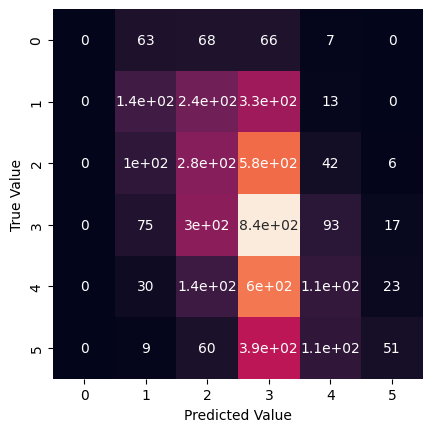

In [318]:
y_pred = knn.predict(X_test)
mat1 = confusion_matrix(y_test, y_pred)
sns.heatmap(mat1, square = True, annot = True, cbar = False)
plt.xlabel('Predicted Value')
plt.ylabel('True Value')

The confusion matrix looks kinda weird...

In [319]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       204
           1       0.34      0.20      0.25       727
           2       0.26      0.28      0.27      1016
           3       0.30      0.64      0.41      1325
           4       0.30      0.13      0.18       903
           5       0.53      0.08      0.14       617

    accuracy                           0.30      4792
   macro avg       0.29      0.22      0.21      4792
weighted avg       0.31      0.30      0.26      4792



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Wow a 0.30 accuracy! Maybe we can try different values of k to see if we can do better.

Text(0, 0.5, 'Accuracy')

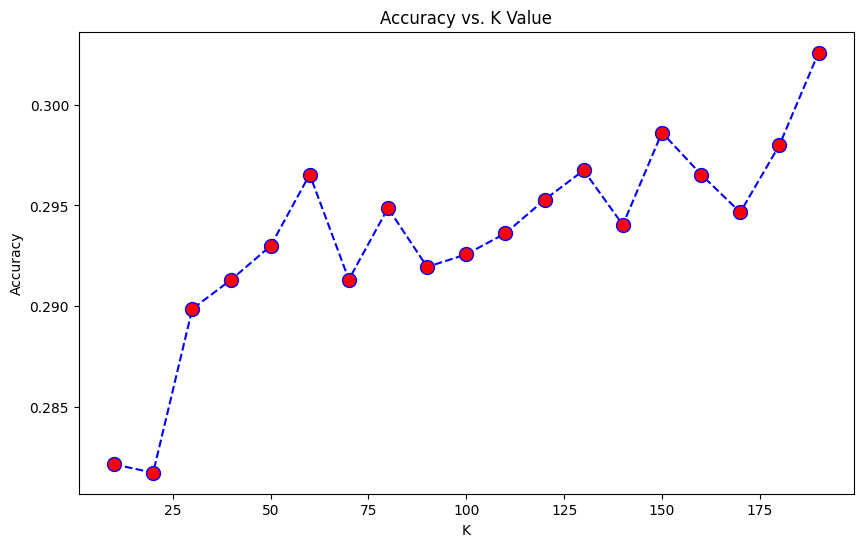

In [320]:
accuracy = []

for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=i*10)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    accuracy.append(np.mean(pred_i == y_test))

plt.figure(figsize=(10,6))
plt.plot(range(10,200,10),accuracy,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')

On the bright side we can pretty accurately predict what isn't their stress level?

## Part 4: Fine-tuning and Optimization

Given such a low accuracy we need to make some drastic changes. How about binary encoding our target feature to only have values 0 or 1.

### Binary Classification

In [321]:
def fun(val: int) -> int:
    assert val in [*range(0, 5+1)]
    return val // 3

df['DAILY_STRESS'] = df['DAILY_STRESS'].apply(fun)

print(df['DAILY_STRESS'].describe())

X = df.drop(['DAILY_STRESS'], axis = 1)
y = df['DAILY_STRESS']

count    15972.000000
mean         0.589219
std          0.491991
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: DAILY_STRESS, dtype: float64


In [322]:
# Scaling the features

# scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 180)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(11180, 22)
(4792, 22)


Text(0, 0.5, 'Accuracy')

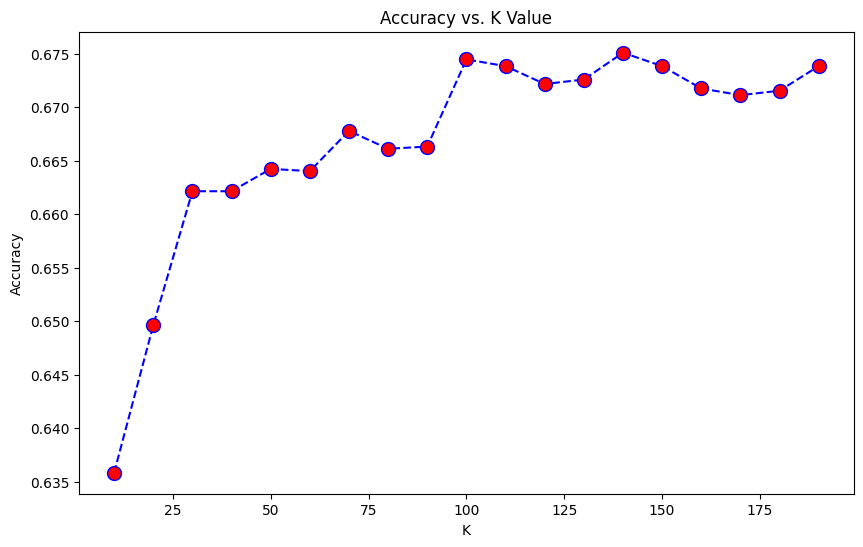

In [323]:
accuracy = []

for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=i*10)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    accuracy.append(np.mean(pred_i == y_test))

plt.figure(figsize=(10,6))
plt.plot(range(10,200,10),accuracy,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')

Unfortunately we were not able to reach a satisfactory accuracy, let's look into using a different model.

### Multilayer Perceptron

Let's try neural networks!

In [324]:
X = df_copy.drop(['DAILY_STRESS'], axis = 1)
y = df_copy['DAILY_STRESS']

# Scaling the features
scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 180)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(11180, 22)
(4792, 22)


In [325]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(5),max_iter=10000,learning_rate_init=0.001,activation='tanh')
mlp.fit(X_train, y_train)

predictions = mlp.predict(X_test)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       204
           1       1.00      1.00      1.00       727
           2       1.00      1.00      1.00      1016
           3       1.00      1.00      1.00      1325
           4       1.00      1.00      1.00       903
           5       1.00      1.00      1.00       617

    accuracy                           1.00      4792
   macro avg       1.00      1.00      1.00      4792
weighted avg       1.00      1.00      1.00      4792



Wow what a difference! perfect accuracy!

Text(113.9222222222222, 0.5, 'True Value')

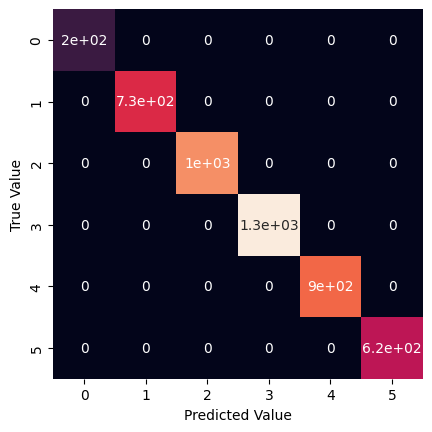

In [326]:
mat = confusion_matrix(y_test, predictions)
sns.heatmap(mat, square = True, annot = True, cbar = False)
plt.xlabel('Predicted Value')
plt.ylabel('True Value')

#### Cross-validation and Ensuring No Data Leakage

In [327]:
X_scaled = scaler.fit_transform(X)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=180)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=180)

mlp.fit(X_train, y_train)

cv_scores = cross_val_score(mlp, X_train, y_train, cv=10, n_jobs=-1)#
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Predict on validation set
y_val_pred = mlp.predict(X_val)
print("Validation set classification report:")
print(classification_report(y_val, y_val_pred))

# Predict on test set
y_test_pred = mlp.predict(X_test)
print("Test set classification report:")
print(classification_report(y_test, y_test_pred))

Cross-validation scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean cross-validation score: 1.0
Validation set classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       132
           1       1.00      1.00      1.00       479
           2       1.00      1.00      1.00       683
           3       1.00      1.00      1.00       879
           4       1.00      1.00      1.00       602
           5       1.00      1.00      1.00       419

    accuracy                           1.00      3194
   macro avg       1.00      1.00      1.00      3194
weighted avg       1.00      1.00      1.00      3194

Test set classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       128
           1       1.00      1.00      1.00       508
           2       1.00      1.00      1.00       684
           3       1.00      1.00      1.00       889
           4       1.00   